# Summary
This notebook applies the baseline methods for retrieving the corresponding connectivity backbones from fMRI data. Subsequently, it plots the results in the paper.

# Libraries

In [1]:
import sys
sys.path.insert(0, r"..\code")

import numpy as np
import pandas as pd

from copy import deepcopy
from utils import save_obj, load_obj
from sklearn.feature_selection import mutual_info_regression
from itertools import combinations
from tqdm.notebook import trange
from pdc_dtf import compute_order, mvar_fit, DTF, PDC
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt


# Data

In [2]:
data_dir="../data/"
ts_dir="../data/TimeSeriesAAL/" 
processed="../data/processed/"
diffreg="../data/processed/diff_regions/"
fig_dir="../figs/"

In [3]:
X_skt_0_L = load_obj('0.0_ts_ss_0_L',processed)
X_skt_1_L = load_obj('0.0_ts_ss_1_L',processed)
X_skt_0_R = load_obj('0.0_ts_ss_0_R',processed)
X_skt_1_R = load_obj('0.0_ts_ss_1_R',processed)

X_skt_L=np.concatenate((X_skt_0_L,X_skt_1_L),axis=0)
X_skt_R=np.concatenate((X_skt_0_R,X_skt_1_R),axis=0)

X_skt_L.shape,X_skt_R.shape

((200, 45, 1200), (200, 45, 1200))

In [4]:
S,K,T=X_skt_L.shape

# Compute functional connectivity measures

In [5]:
replace = False
verbose = False

In [6]:
if replace:
    results = dict()
    results['single scale']=load_obj('1.2_results_bootstrap_ss_cut_idiosyncratic_0.2', processed)
    results['multiscale']=load_obj('1.2_results_bootstrap_ms_cut_idiosyncratic_0.2', processed)

    #Set the same threshold and persistence 
    #used for causal connections. Persistence
    #applies separately over the days.
    t=.2 #threshold
    p=80 #persistence

    #Initialize dict keys
    results['mutual info']=dict()
    results['correlation']=dict()
    results['partial correlation']=dict()
    results['DTF']=dict()
    results['PDC']=dict()

    results['mutual info']['left']=dict()
    results['mutual info']['right']=dict()

    results['correlation']['left']=dict()
    results['correlation']['right']=dict()

    results['partial correlation']['left']=dict()
    results['partial correlation']['right']=dict()

    results['DTF']['left']=dict()
    results['DTF']['right']=dict()

    results['PDC']['left']=dict()
    results['PDC']['right']=dict()

    #tensors
    mutual_info_tensor_L = np.zeros((S,K,K))
    mutual_info_tensor_R = np.zeros((S,K,K))

    correlation_tensor_L = np.zeros((S,K,K))
    correlation_tensor_R = np.zeros((S,K,K))

    partial_correlation_tensor_L = np.zeros((S,K,K))
    partial_correlation_tensor_R = np.zeros((S,K,K))

    DTF_L = np.zeros((S,K,K))
    DTF_R = np.zeros((S,K,K))

    PDC_L = np.zeros((S,K,K))
    PDC_R = np.zeros((S,K,K))

    for s in trange(S):

        ts_L = X_skt_L[s].T
        ts_R = X_skt_R[s].T
            
        mutual_info_tensor_L[s] = np.eye(K)
        mutual_info_tensor_R[s] = np.eye(K)

        for i in range(K-1):
            mutual_info_tensor_L[s][i,i+1:] += mutual_info_regression(ts_L[...,i+1:], ts_L[...,i])
            mutual_info_tensor_R[s][i,i+1:] += mutual_info_regression(ts_R[...,i+1:], ts_R[...,i])

        mutual_info_tensor_L[s]+=np.triu(mutual_info_tensor_L[s],k=1).T
        mutual_info_tensor_R[s]+=np.triu(mutual_info_tensor_R[s],k=1).T

        P_L = np.linalg.inv(np.cov(ts_L, rowvar=False))
        D_L = np.diag(np.diag(P_L)**(-1/2))
        R_L = - D_L @ P_L @ D_L

        P_R = np.linalg.inv(np.cov(ts_R, rowvar=False))
        D_R = np.diag(np.diag(P_R)**(-1/2))
        R_R = - D_R @ P_R @ D_R

        partial_correlation_tensor_L[s]+=R_L
        partial_correlation_tensor_R[s]+=R_R

        correlation_tensor_L[s]+=np.corrcoef(ts_L, rowvar=False)
        correlation_tensor_R[s]+=np.corrcoef(ts_R, rowvar=False)
        
        #LEFT
        p_max = 10 #autoregressive lags to be tested
        p, bic = compute_order(ts_L.T, p_max=p_max)
        if p==0: p=1

        A_est, sigma = mvar_fit(ts_L.T, p)
        sigma = np.diag(sigma)  # DTF + PDC support diagonal noise

        dtf, _ = DTF(A_est, sigma)
        dtf1=np.linalg.norm(dtf, ord=2, axis=0)
        ddtf1=np.diag(np.diag(dtf1)**(-.5))
        dtf2=ddtf1@dtf1@ddtf1
        DTF_L[s] += dtf2.T

        pdc, _ = PDC(A_est, sigma)
        pdc1=np.linalg.norm(pdc, ord=2, axis=0)
        dpdc1=np.diag(np.diag(pdc1)**(-.5))
        pdc2=dpdc1@pdc1@dpdc1
        PDC_L[s] += pdc2.T   

        #RIGHT
        p_max = 10
        p, bic = compute_order(ts_R.T, p_max=p_max)
        if p==0: p=1
        
        A_est, sigma = mvar_fit(ts_R.T, p)
        sigma = np.diag(sigma)  # DTF + PDC support diagonal noise

        dtf, _ = DTF(A_est, sigma)
        dtf1=np.linalg.norm(dtf, ord=2, axis=0)
        ddtf1=np.diag(np.diag(dtf1)**(-.5))
        dtf2=ddtf1@dtf1@ddtf1
        DTF_R[s] += dtf2.T

        pdc, _ = PDC(A_est, sigma)
        pdc1=np.linalg.norm(pdc, ord=2, axis=0)
        dpdc1=np.diag(np.diag(pdc1)**(-.5))
        pdc2=dpdc1@pdc1@dpdc1
        PDC_R[s] += pdc2.T

    #LEFT
    #undirected are symmetric
    A_Corr_skk_l = np.triu(np.where(np.abs(correlation_tensor_L)>t, 1, 0), k=1)
    A_MI_skk_l = np.triu(np.where(np.abs(mutual_info_tensor_L)>t, 1, 0), k=1)
    A_PC_skk_l = np.triu(np.where(np.abs(partial_correlation_tensor_L)>t, 1, 0), k=1)
    #directed are not symmetric
    A_DTF_skk_l = np.where(np.abs(DTF_L)>t, 1, 0)
    A_PDC_skk_l = np.where(np.abs(PDC_L)>t, 1, 0)

    #apply persistence over single days
    B_corr_l = np.where(np.sum(A_Corr_skk_l[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_Corr_skk_l[S:], axis=0)>=p, 1, 0)
    B_corr_l = np.where(B_corr_l>0,1,0)
    
    B_MI_l = np.where(np.sum(A_MI_skk_l[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_MI_skk_l[S:], axis=0)>=p, 1, 0)
    B_MI_l = np.where(B_MI_l>0,1,0)

    B_PC_l = np.where(np.sum(A_PC_skk_l[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_PC_skk_l[S:], axis=0)>=p, 1, 0)
    B_PC_l = np.where(B_PC_l>0,1,0)

    B_DTF_l = np.where(np.sum(A_DTF_skk_l[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_DTF_skk_l[S:], axis=0)>=p, 1, 0)
    B_DTF_l = np.where(B_DTF_l>0,1,0)

    B_PDC_l = np.where(np.sum(A_PDC_skk_l[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_PDC_skk_l[S:], axis=0)>=p, 1, 0)
    B_PDC_l = np.where(B_PDC_l>0,1,0)

    #use the median as weight
    W_corr_l = np.percentile(correlation_tensor_L, 50, axis=0) * B_corr_l
    W_MI_l = np.percentile(mutual_info_tensor_L, 50, axis=0) * B_MI_l
    W_PC_l = np.percentile(partial_correlation_tensor_L, 50, axis=0) * B_PC_l
    W_DTF_l = np.percentile(DTF_L, 50, axis=0) * B_DTF_l
    W_PDC_l = np.percentile(PDC_L, 50, axis=0) * B_PDC_l

    #RIGHT
    A_Corr_skk_r = np.triu(np.where(np.abs(correlation_tensor_R)>t, 1, 0), k=1)
    A_MI_skk_r = np.triu(np.where(np.abs(mutual_info_tensor_R)>t, 1, 0), k=1)
    A_PC_skk_r = np.triu(np.where(np.abs(partial_correlation_tensor_R)>t, 1, 0), k=1)
    A_DTF_skk_r = np.where(np.abs(DTF_R)>t, 1, 0)
    A_PDC_skk_r = np.where(np.abs(PDC_R)>t, 1, 0)

    B_corr_r = np.where(np.sum(A_Corr_skk_r[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_Corr_skk_r[S:], axis=0)>=p, 1, 0)
    B_corr_r = np.where(B_corr_r>0,1,0)
    
    B_MI_r = np.where(np.sum(A_MI_skk_r[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_MI_skk_r[S:], axis=0)>=p, 1, 0)
    B_MI_r = np.where(B_MI_r>0,1,0)

    B_PC_r = np.where(np.sum(A_PC_skk_r[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_PC_skk_r[S:], axis=0)>=p, 1, 0)
    B_PC_r = np.where(B_PC_r>0,1,0)

    B_DTF_r = np.where(np.sum(A_DTF_skk_r[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_DTF_skk_r[S:], axis=0)>=p, 1, 0)
    B_DTF_r = np.where(B_DTF_r>0,1,0)

    B_PDC_r = np.where(np.sum(A_PDC_skk_r[:S], axis=0)>=p, 1, 0) + np.where(np.sum(A_PDC_skk_r[S:], axis=0)>=p, 1, 0)
    B_PDC_r = np.where(B_PDC_r>0,1,0)

    W_corr_r = np.percentile(correlation_tensor_R, 50, axis=0) * B_corr_r
    W_MI_r = np.percentile(mutual_info_tensor_R, 50, axis=0) * B_MI_r
    W_PC_r = np.percentile(partial_correlation_tensor_R, 50, axis=0) * B_PC_r
    W_DTF_r = np.percentile(DTF_R, 50, axis=0) * B_DTF_r
    W_PDC_r = np.percentile(PDC_R, 50, axis=0) * B_PDC_r

    results['mutual info']['left']['MI stacked tensor']=mutual_info_tensor_L
    results['mutual info']['right']['MI stacked tensor']=mutual_info_tensor_R

    results['correlation']['left']['CR stacked tensor']=correlation_tensor_L
    results['correlation']['right']['CR stacked tensor']=correlation_tensor_R

    results['partial correlation']['left']['PC stacked tensor']=partial_correlation_tensor_L
    results['partial correlation']['right']['PC stacked tensor']=partial_correlation_tensor_R

    results['DTF']['left']['DTF stacked tensor']=DTF_L
    results['DTF']['right']['DTF stacked tensor']=DTF_R

    results['PDC']['left']['PDC stacked tensor']=PDC_L
    results['PDC']['right']['PDC stacked tensor']=PDC_R

    results['mutual info']['left']['MI tensor']=W_MI_l
    results['mutual info']['right']['MI tensor']=W_MI_r

    results['correlation']['left']['CR tensor']=W_corr_l
    results['correlation']['right']['CR tensor']=W_corr_r

    results['partial correlation']['left']['PC tensor']=W_PC_l
    results['partial correlation']['right']['PC tensor']=W_PC_r

    results['DTF']['left']['DTF tensor']=W_DTF_l
    results['DTF']['right']['DTF tensor']=W_DTF_r

    results['PDC']['left']['PDC tensor']=W_PDC_l
    results['PDC']['right']['PDC tensor']=W_PDC_r

    results['mutual info']['left']['MI solution']=B_MI_l
    results['mutual info']['right']['MI solution']=B_MI_r

    results['correlation']['left']['CR solution']=B_corr_l
    results['correlation']['right']['CR solution']=B_corr_r

    results['partial correlation']['left']['PC solution']=B_PC_l
    results['partial correlation']['right']['PC solution']=B_PC_r

    results['DTF']['left']['DTF solution']=B_DTF_l
    results['DTF']['right']['DTF solution']=B_DTF_r

    results['PDC']['left']['PDC solution']=B_PDC_l
    results['PDC']['right']['PDC solution']=B_PDC_r

    save_obj(results, "1.3_results_comparison_real_data", processed)

else:
    results=load_obj("1.3_results_comparison_real_data", processed)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Plot the results

In [7]:
import igraph as ig

In [8]:
hemis = ['left', 'right']
names = pd.DataFrame(results['single scale']['map_idx_to_regions']).loc['Region']
colors = pd.DataFrame(results['single scale']['map_idx_to_regions']).loc['Color']

tnodes=[0,1,23,25,26,30,39]
tckns = np.ones(len(names), dtype=int)

fcnodes=["green", "red", "purple", "magenta", "magenta", "red", "orange"]
fillcol=len(names)*["white"]

for n,i in enumerate(tnodes):
    tckns[i]=3
    fillcol[i]=fcnodes[n]

############### left ###############


######## MULTISCALE ########


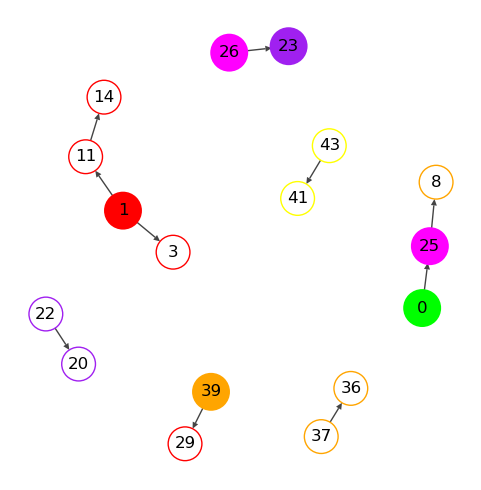

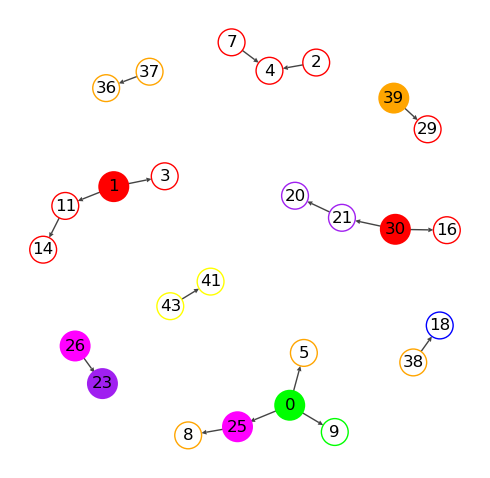

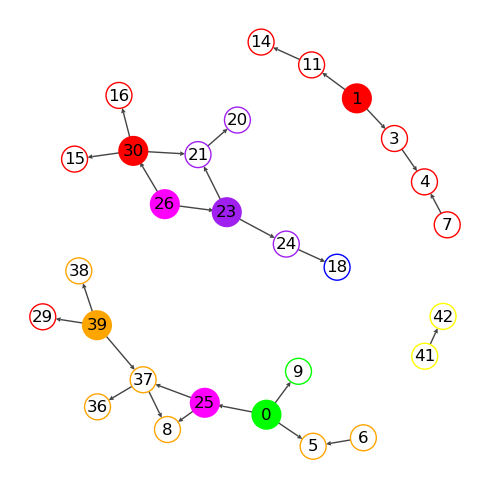

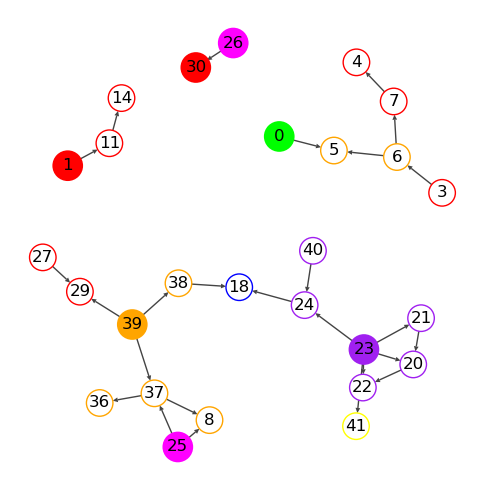

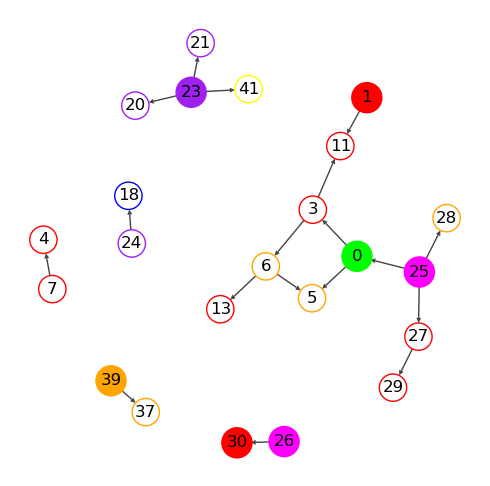

######## SINGLE SCALE ########


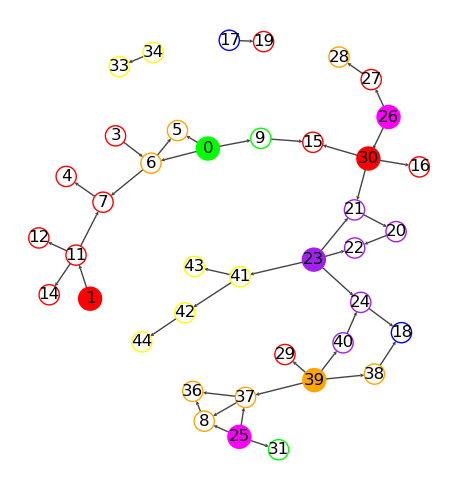

######## MI ########


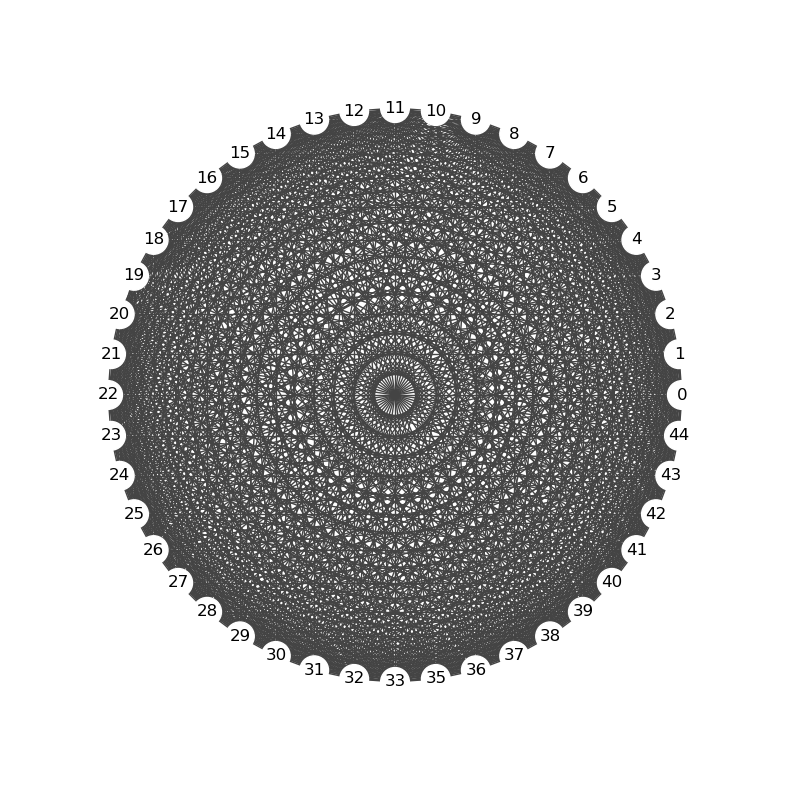

######## CORR ########


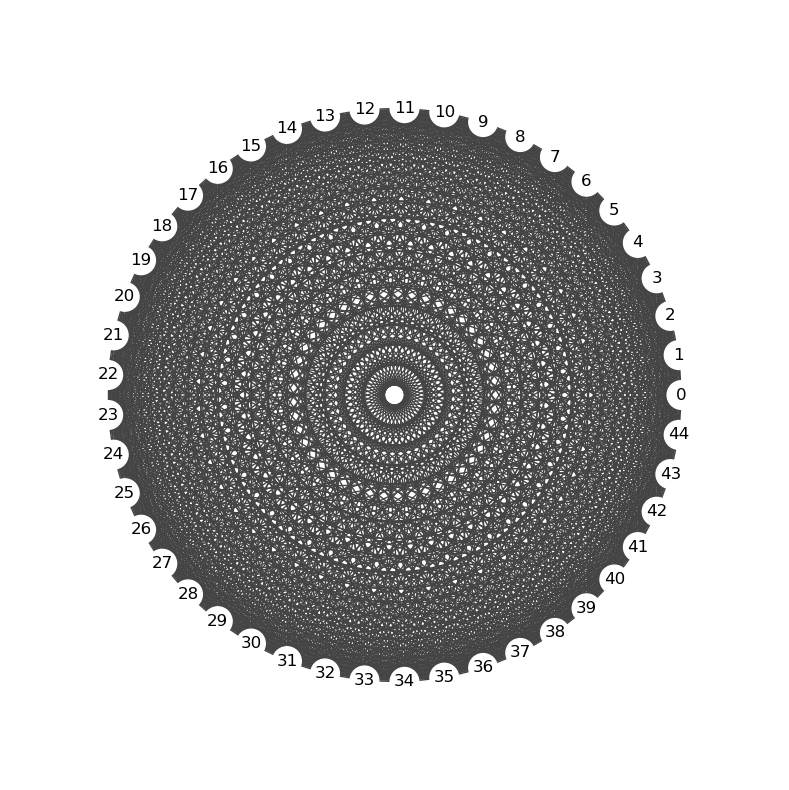

######## PARTIAL CORR ########


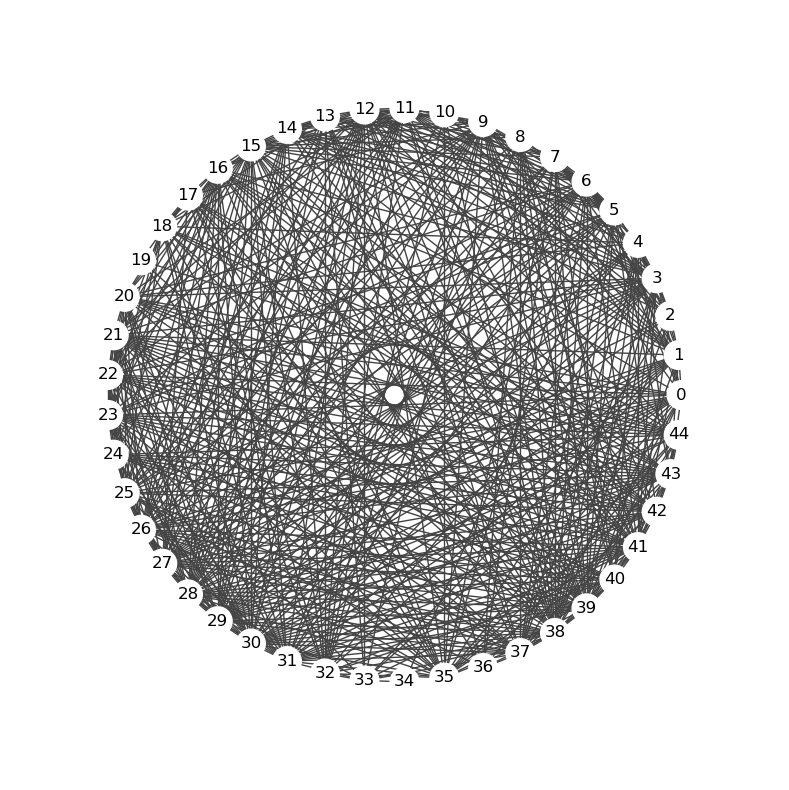

######## DTF ########


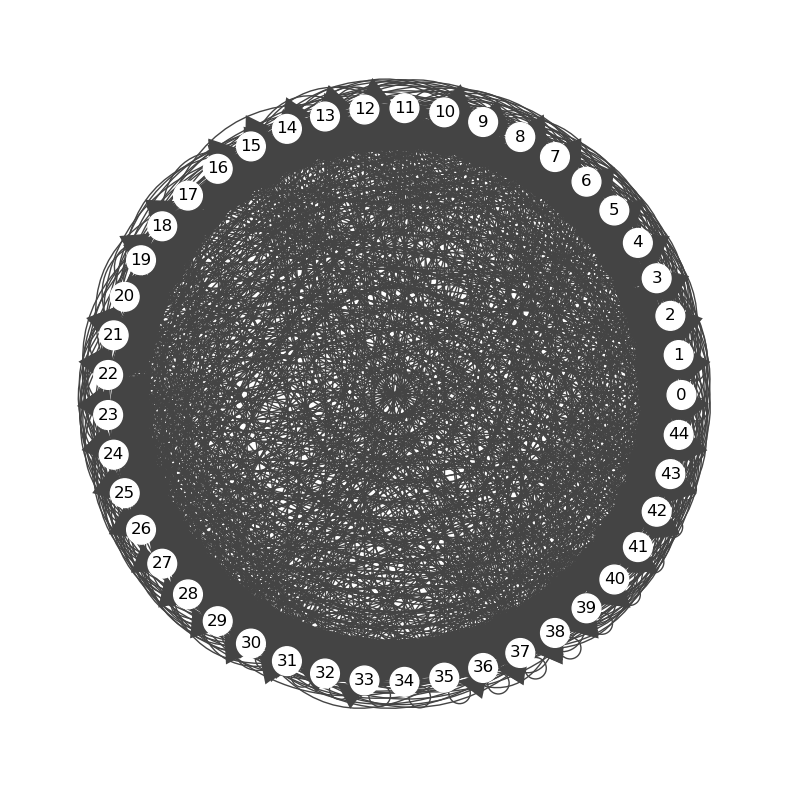

######## PDC ########


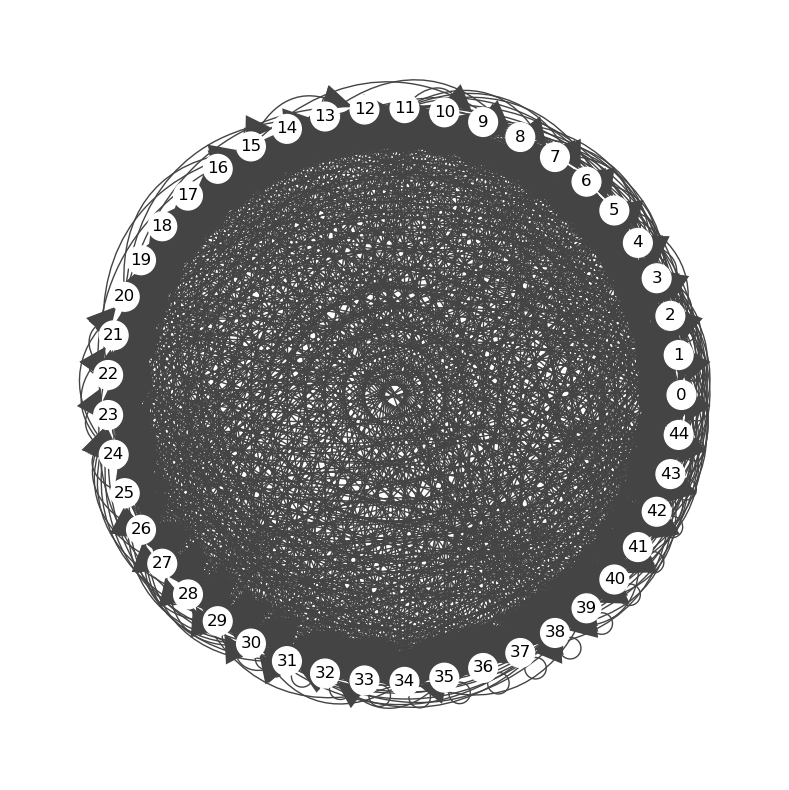

############### right ###############


######## MULTISCALE ########


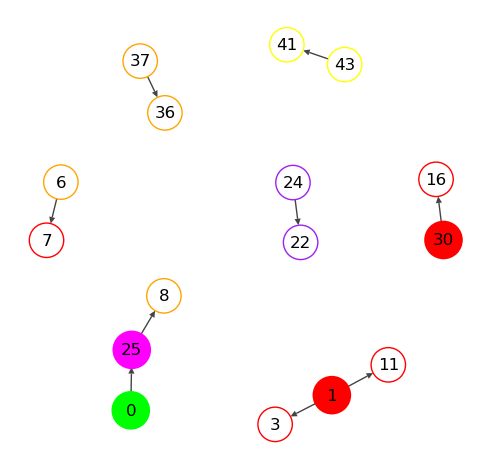

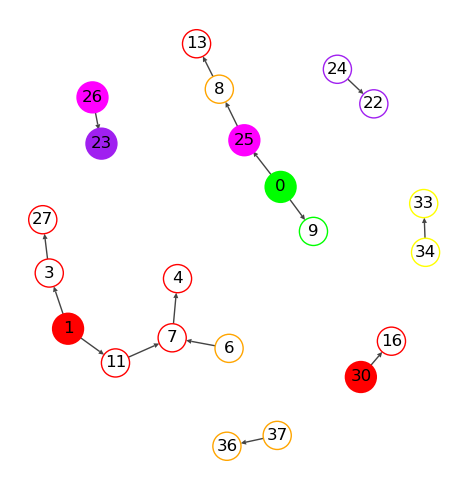

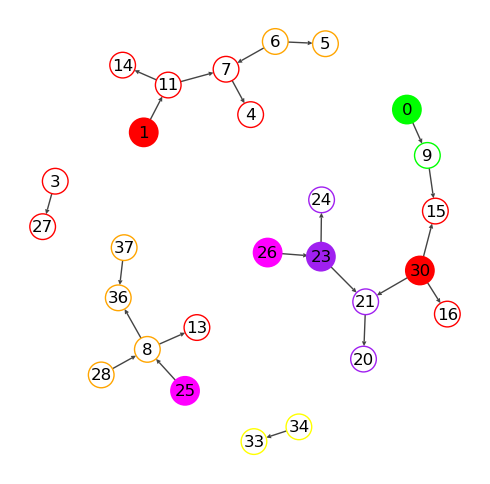

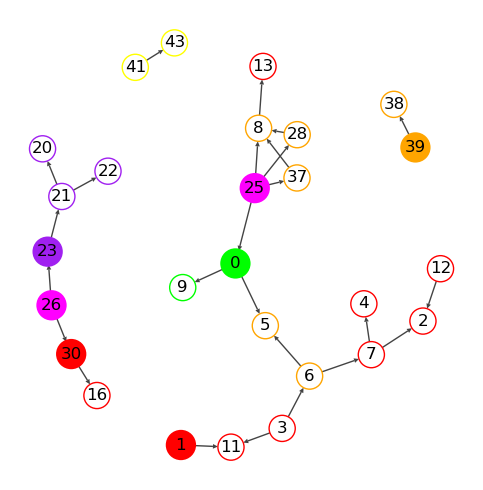

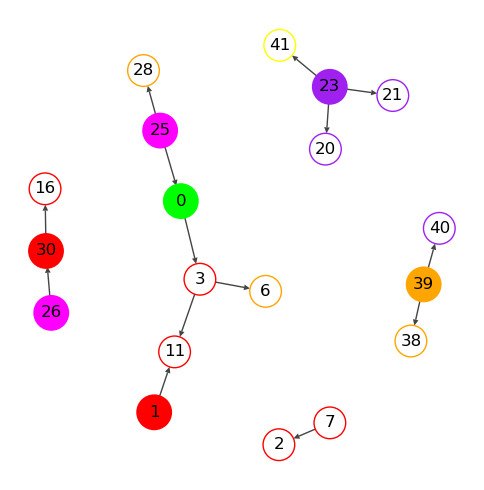

######## SINGLE SCALE ########


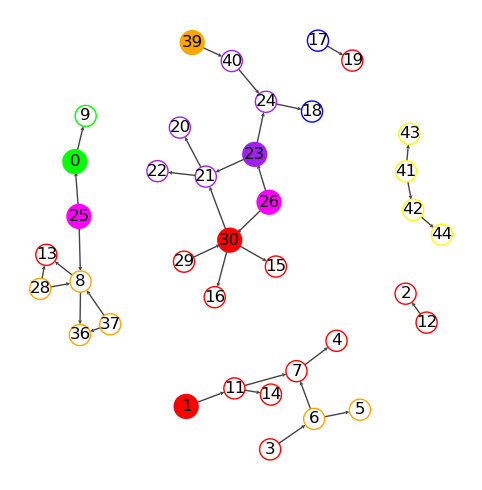

######## MI ########


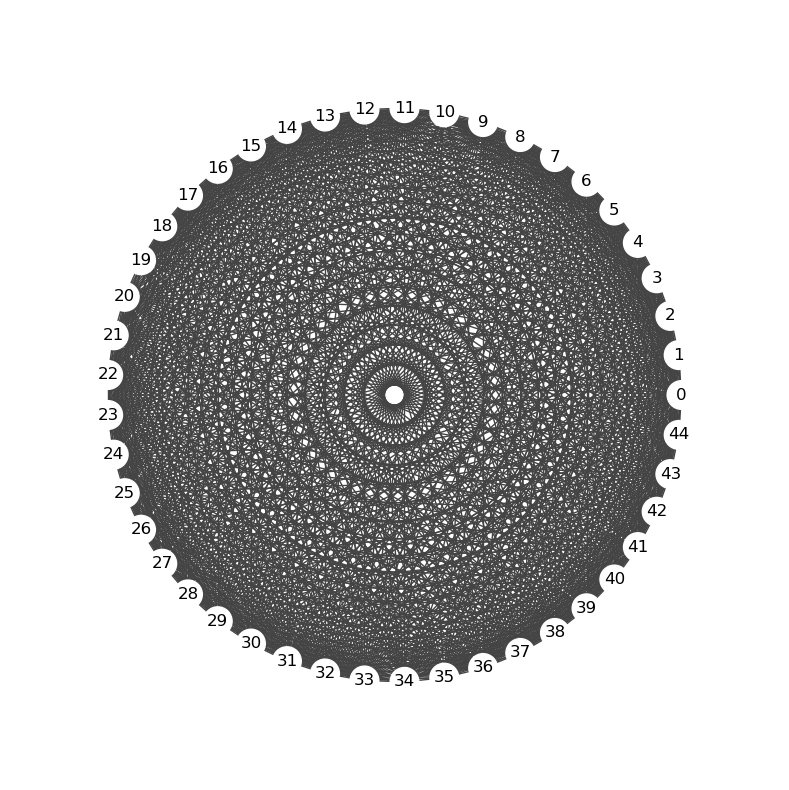

######## CORR ########


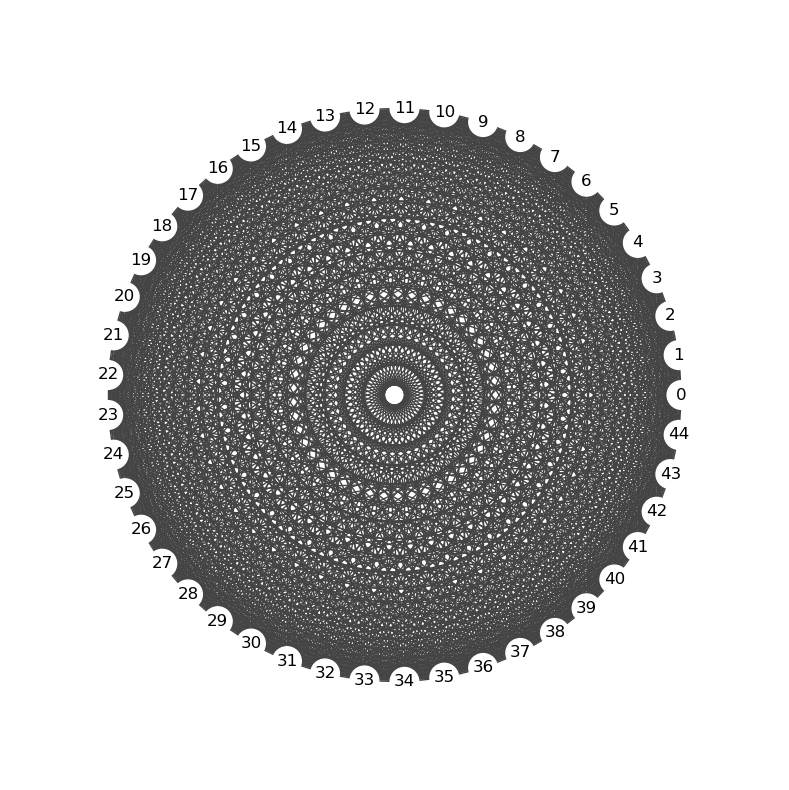

######## PARTIAL CORR ########


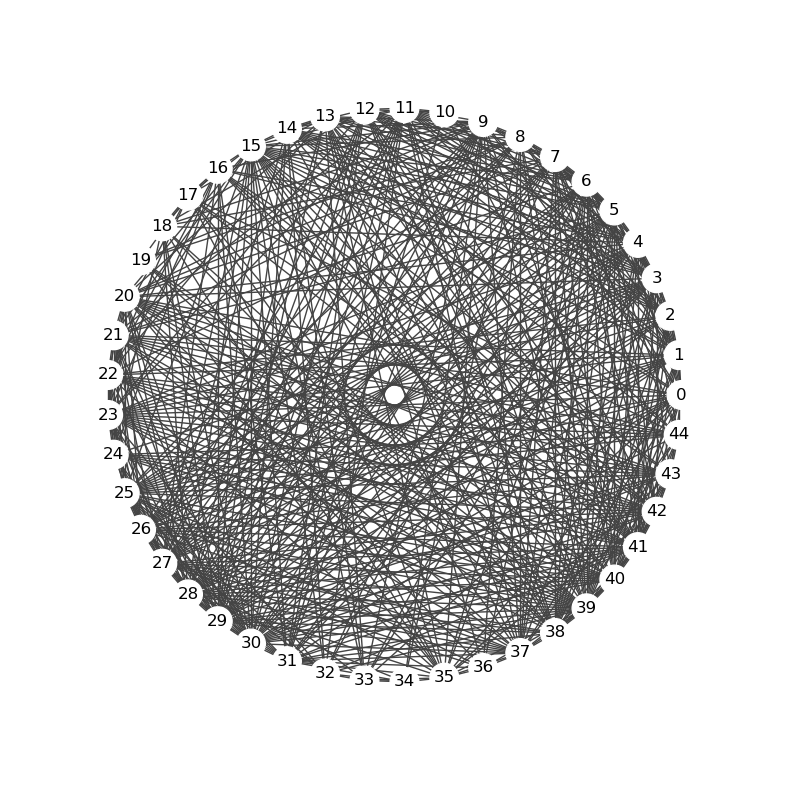

######## DTF ########


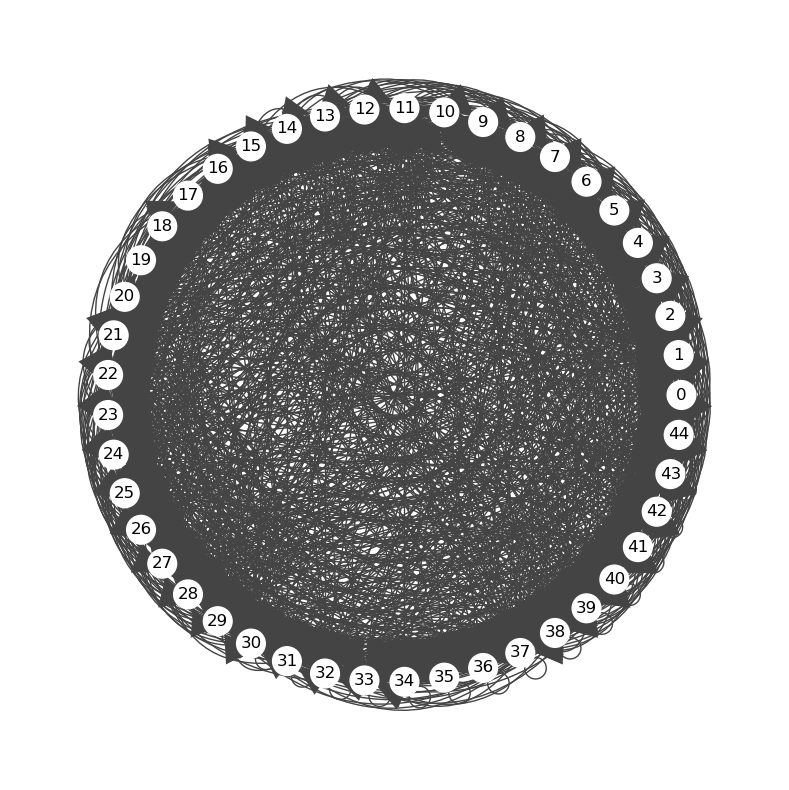

######## PDC ########


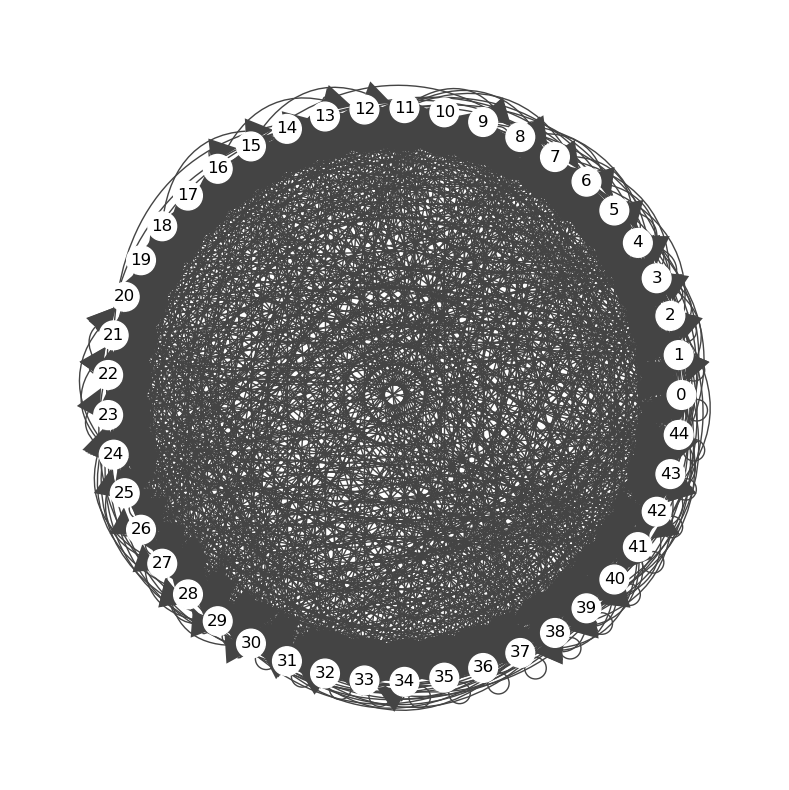

In [9]:
hemis = ['left', 'right']
names = pd.DataFrame(results['single scale']['map_idx_to_regions']).loc['Region']
colors = pd.DataFrame(results['single scale']['map_idx_to_regions']).loc['Color']
label_font = ("Arial", 12)

for i in colors.index:
    if colors.iloc[i]=='blu': colors.iloc[i]='blue'

for hemi in hemis:
    print("############### {} ###############\n\n".format(hemi))

    print("######## MULTISCALE ########")
    for scale in list(results['multiscale']['bootstrap results']['left'].keys()):
        dag=ig.Graph.Weighted_Adjacency(results['multiscale']['bootstrap results'][hemi][scale]['Causal tensor'].tolist())
        dag.vs["name"] = range(len(names))
        dag.vs["colors"] = colors
        dag.vs["vertex_frame_width"] = tckns
        dag.vs["vertex_color"]=fillcol
        dag.vs.select(_degree_eq=0).delete()
        co= dag.topological_sorting(mode='out')

        fig, ax = plt.subplots(figsize=(5, 5))
        ig.plot(
                dag,
                target=ax,
                layout='fr',
                vertex_size=.5,
                vertex_frame_color=dag.vs.get_attribute_values("colors"),
                vertex_frame_width=dag.vs.get_attribute_values("vertex_frame_width"),
                edge_width=1,
                vertex_label=dag.vs.get_attribute_values("name"),
                vertex_color=dag.vs.get_attribute_values("vertex_color"),
            )
        plt.tight_layout()
        # plt.savefig(fig_dir+"1.3_multiscale_{}_{}.pdf".format(hemi, scale), dpi=1200, bbox_inches="tight")
        plt.show()
    
    print("######## SINGLE SCALE ########")
    dag=ig.Graph.Weighted_Adjacency(results['single scale']['bootstrap results'][hemi]['Causal tensor'].tolist())
    dag.vs["name"] = range(len(names))
    dag.vs["colors"] = colors
    dag.vs["vertex_frame_width"] = tckns
    dag.vs["vertex_color"]=fillcol
    dag.vs.select(_degree_eq=0).delete()
    co= dag.topological_sorting(mode='out')

    fig, ax = plt.subplots(figsize=(5, 5))
    ig.plot(
            dag,
            target=ax,
            layout='fr',
            vertex_size=.5,
            vertex_frame_color=dag.vs.get_attribute_values("colors"),
            vertex_frame_width=dag.vs.get_attribute_values("vertex_frame_width"),
            edge_width=1,
            vertex_label=dag.vs.get_attribute_values("name"),
            vertex_color=dag.vs.get_attribute_values("vertex_color")
        )
    plt.tight_layout()
    plt.savefig(fig_dir+"1.3_single_scale_{}.pdf".format(hemi), dpi=1200, bbox_inches="tight")
    plt.show()
    
    print('######## MI ########')
    mi = ig.Graph.Weighted_Adjacency((results['mutual info'][hemi]['MI tensor']+results['mutual info'][hemi]['MI tensor'].T).tolist(), mode='lower')
    mi.vs["name"] = range(len(names))
    mi.vs.select(_degree_eq=0).delete()

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
            mi,
            target=ax,
            layout='circle',
            vertex_size=.1,
            vertex_frame_color="white",
            edge_width=1,
            vertex_label=mi.vs.get_attribute_values("name"),
            vertex_color="white",
        )
    plt.tight_layout()
    # plt.savefig(fig_dir+"1.3_mi_{}.pdf".format(hemi), dpi=1200, bbox_inches="tight")
    plt.show()

    print('######## CORR ########')

    corr = ig.Graph.Weighted_Adjacency((results['correlation'][hemi]['CR tensor']+results['correlation'][hemi]['CR tensor'].T).tolist(), mode='lower')
    corr.vs["name"] = range(len(names))
    corr.vs.select(_degree_eq=0).delete()

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
            corr,
            target=ax,
            layout='circle',
            vertex_size=.1,
            vertex_frame_color="white",
            edge_width=1,
            vertex_label=corr.vs.get_attribute_values("name"),
            vertex_color="white",
        )
    plt.tight_layout()
    # plt.savefig(fig_dir+"1.3_corr_{}.pdf".format(hemi), dpi=1200, bbox_inches="tight")
    plt.show()

    print('######## PARTIAL CORR ########')

    pcorr = ig.Graph.Weighted_Adjacency((results['partial correlation'][hemi]['PC tensor']+results['partial correlation'][hemi]['PC tensor'].T).tolist(), mode='lower')
    pcorr.vs["name"] = range(len(names))
    pcorr.vs.select(_degree_eq=0).delete()

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
            pcorr,
            target=ax,
            layout='circle',
            vertex_size=.1,
            vertex_frame_color="white",
            edge_width=1,
            vertex_label=pcorr.vs.get_attribute_values("name"),
            vertex_color="white",
        )
    plt.tight_layout()
    # plt.savefig(fig_dir+"1.3_pcorr_{}.pdf".format(hemi), dpi=1200, bbox_inches="tight")
    plt.show()
    
    print('######## DTF ########')

    dtf = ig.Graph.Weighted_Adjacency((results['DTF'][hemi]['DTF tensor']).tolist())
    dtf.vs["name"] = range(len(names))
    dtf.vs.select(_degree_eq=0).delete()

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
            dtf,
            target=ax,
            layout='circle',
            vertex_size=.1,
            vertex_frame_color="white",
            edge_width=1,
            vertex_label=dtf.vs.get_attribute_values("name"),
            vertex_color="white",
        )
    plt.tight_layout()
    # plt.savefig(fig_dir+"1.3_dtf_{}.pdf".format(hemi), dpi=1200, bbox_inches="tight")
    plt.show()

    print('######## PDC ########')

    pdc = ig.Graph.Weighted_Adjacency((results['PDC'][hemi]['PDC tensor']).tolist())
    pdc.vs["name"] = range(len(names))
    pdc.vs.select(_degree_eq=0).delete()

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
            pdc,
            target=ax,
            layout='circle',
            vertex_size=.1,
            vertex_frame_color="white",
            edge_width=1,
            vertex_label=pdc.vs.get_attribute_values("name"),
            vertex_color="white",
        )
    plt.tight_layout()
    # plt.savefig(fig_dir+"1.3_pdc_{}.pdf".format(hemi), dpi=1200, bbox_inches="tight")
    plt.show()

######## MULTISCALE ########


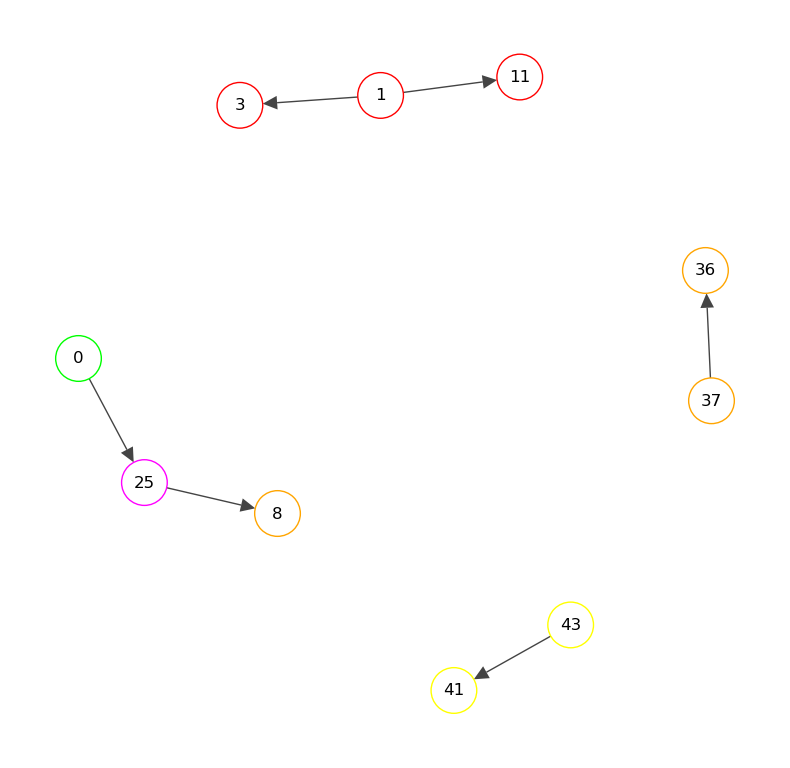

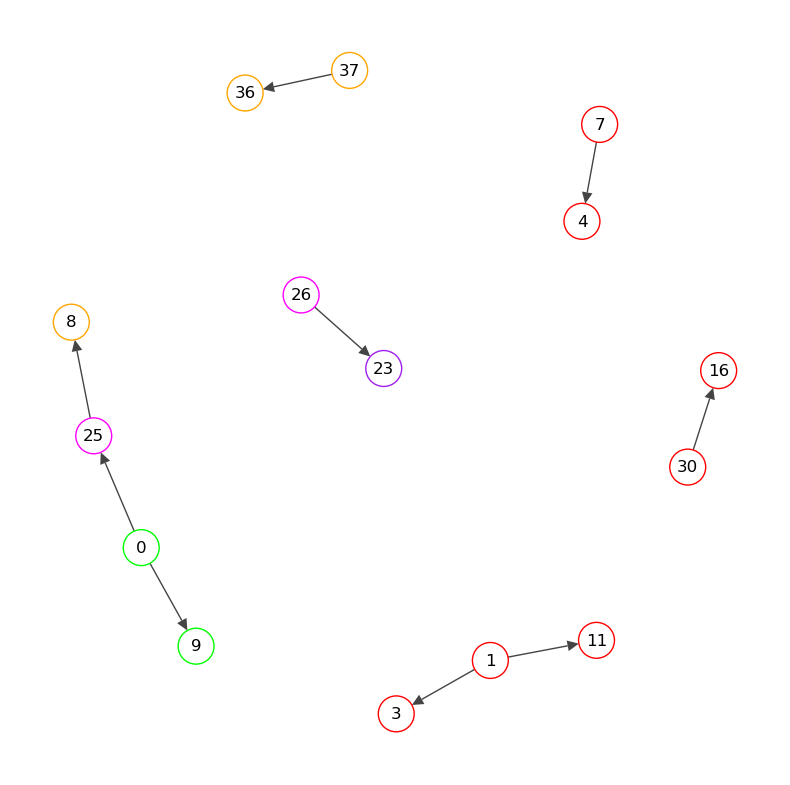

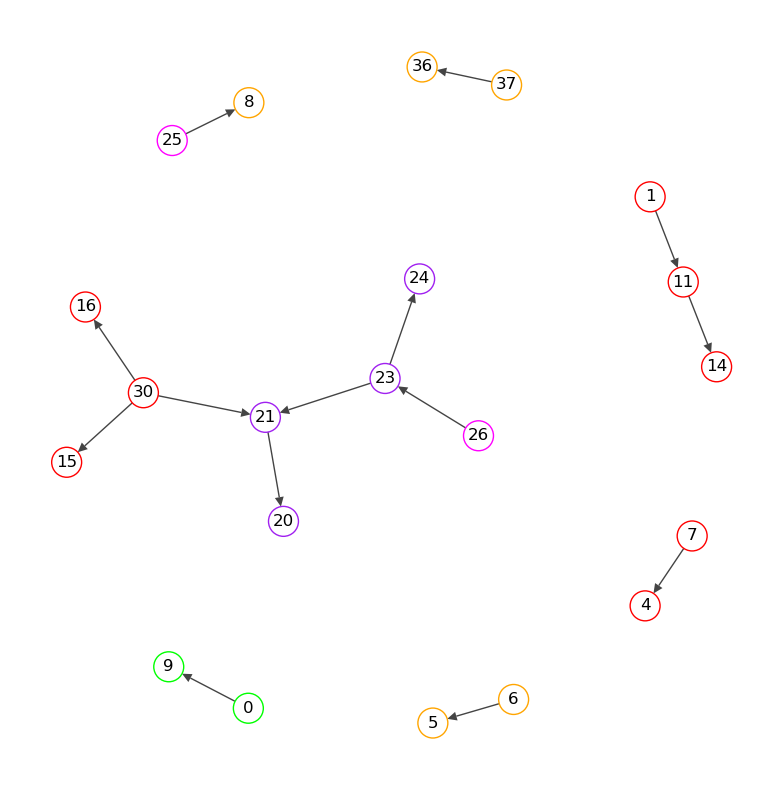

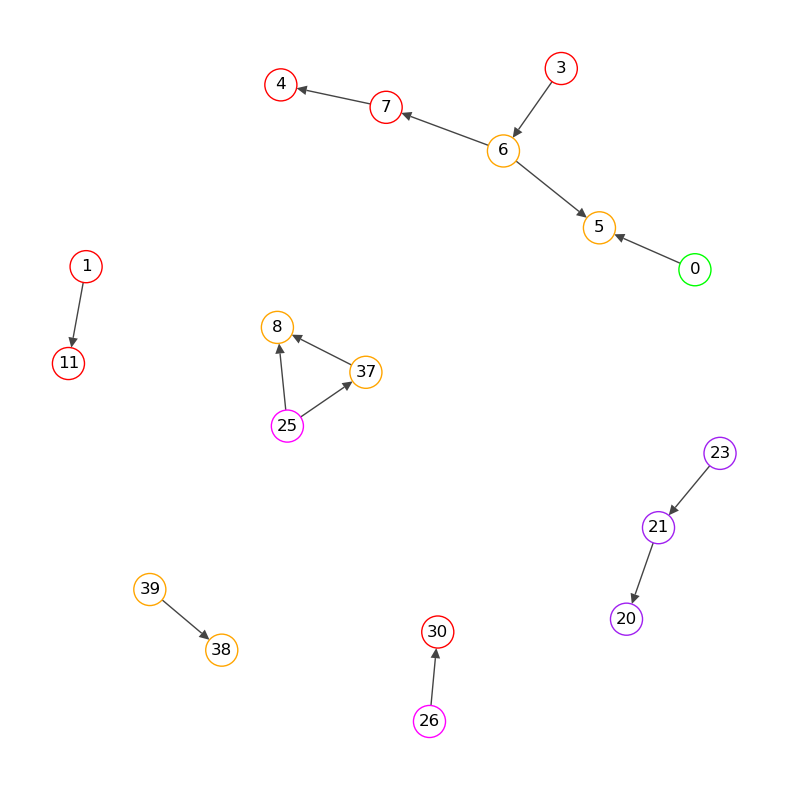

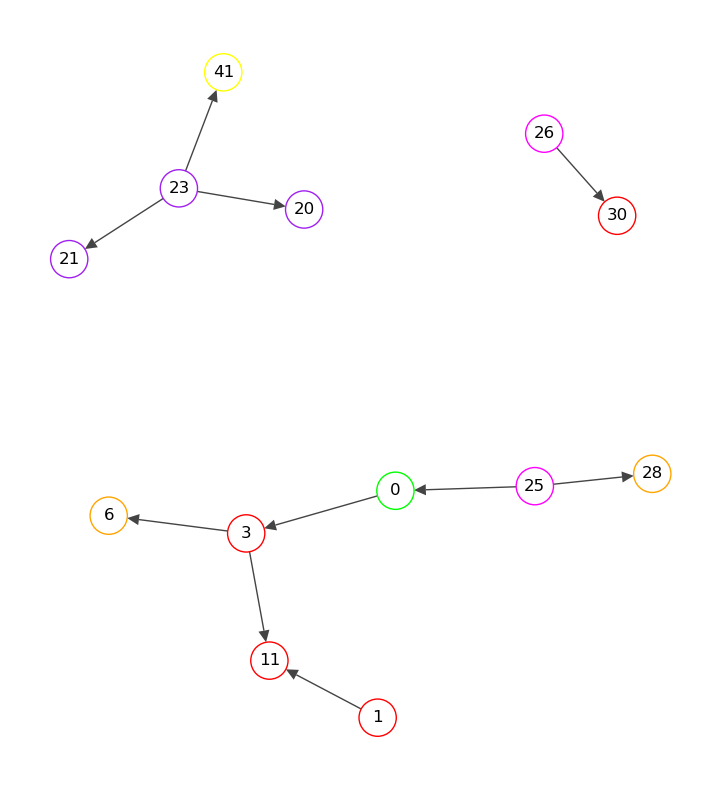

######## SINGLE SCALE ########


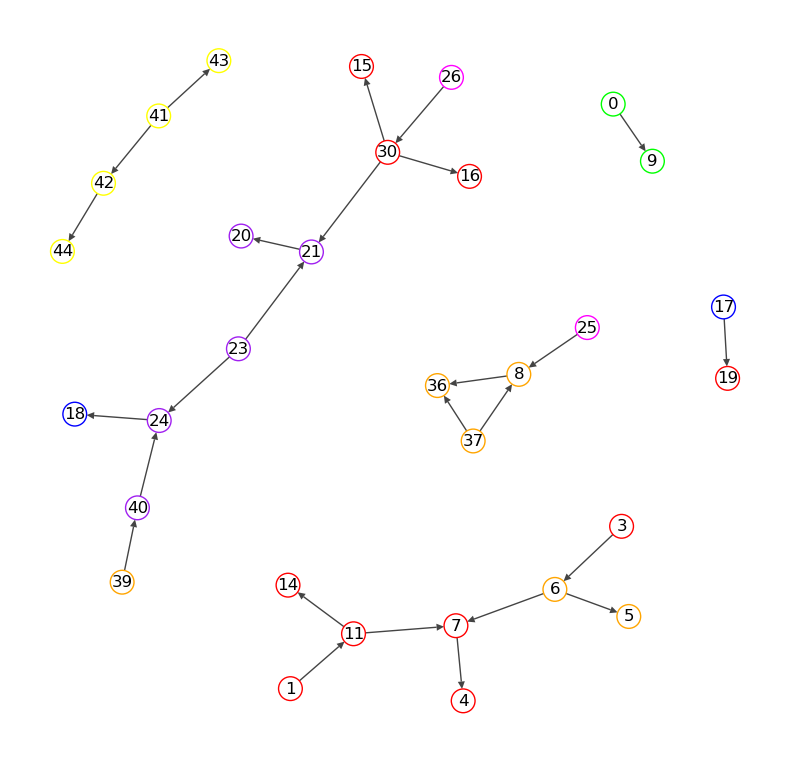

In [10]:
#arcs shared by left and right hemis
print("######## MULTISCALE ########")

for scale in list(results['multiscale']['bootstrap results']['left'].keys()):
    dag=ig.Graph.Weighted_Adjacency((results['multiscale']['bootstrap results']['right'][scale]['Causal tensor']*results['multiscale']['bootstrap results']['left'][scale]['Causal tensor']).tolist())
    dag.vs["name"] = range(len(names))
    dag.vs["colors"] = colors
    dag.vs.select(_degree_eq=0).delete()
    co= dag.topological_sorting(mode='out')

    fig, ax = plt.subplots(figsize=(8, 8))
    ig.plot(
            dag,
            target=ax,
            layout='fr',
            vertex_size=.3,
            vertex_frame_color=dag.vs.get_attribute_values("colors"),
            edge_width=1,
            vertex_label=dag.vs.get_attribute_values("name"),
            vertex_color="white",
        )
    plt.tight_layout()
    # plt.savefig(fig_dir+"1.3_multiscale_{}_shared.pdf".format(scale), dpi=1200, bbox_inches="tight")
    plt.show()


print("######## SINGLE SCALE ########")

dag=ig.Graph.Weighted_Adjacency((results['single scale']['bootstrap results']['right']['Causal tensor']*results['single scale']['bootstrap results']['left']['Causal tensor']).tolist())
dag.vs["name"] = range(len(names))
dag.vs["colors"] = colors
dag.vs.select(_degree_eq=0).delete()
co= dag.topological_sorting(mode='out')

fig, ax = plt.subplots(figsize=(8, 8))
ig.plot(
        dag,
        target=ax,
        layout='fr',
        vertex_size=.3,
        vertex_frame_color=dag.vs.get_attribute_values("colors"),
        edge_width=1,
        vertex_label=dag.vs.get_attribute_values("name"),
        vertex_color="white",
    )
plt.tight_layout()
# plt.savefig(fig_dir+"1.3_single_scale_shared.pdf", dpi=1200, bbox_inches="tight")
plt.show()